# Attentive FP

In [3]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from preprocessing.featurisation import get_atom_features, get_bond_features
from preprocessing.fetch_smiles import resolve_smiles_by_cas_interactive
from preprocessing.smiles_to_graph import batch_from_csv

## Importing the data

In [4]:
graph_list = batch_from_csv("data/processed/input.csv")
molecules_df = pd.read_csv("data/processed/input.csv")
graph_list[:5]

[Data(x=[8, 79], edge_index=[2, 16], edge_attr=[16, 10], y=[1]),
 Data(x=[11, 79], edge_index=[2, 24], edge_attr=[24, 10], y=[1]),
 Data(x=[10, 79], edge_index=[2, 22], edge_attr=[22, 10], y=[1]),
 Data(x=[5, 79], edge_index=[2, 10], edge_attr=[10, 10], y=[1]),
 Data(x=[10, 79], edge_index=[2, 18], edge_attr=[18, 10], y=[1])]

In [5]:
num_node_features = graph_list[0].num_node_features
num_edge_features = graph_list[0].num_edge_features
avg_degree = 2*(graph_list[0].num_edges) / graph_list[0].num_nodes
print(f"Number of node features: {num_node_features}")
print(f"Average degree of the graph: {avg_degree:.2f}") # From the avg. degree we can use at least 4 GCNConv layers
print(f"Number of edge features: {num_edge_features}")


Number of node features: 79
Average degree of the graph: 4.00
Number of edge features: 10


In [6]:
import torch
import random
import numpy as np

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)


## Model Training and Predictive accuracy functions

### Model definition

In [7]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import AttentiveFP

class AttentiveFPModel(torch.nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, out_dim, num_layers=1, timesteps=2, dropout_rate=0.2):
        super().__init__()

        self.attentivefp = AttentiveFP(
            in_channels=node_dim,
            hidden_channels=hidden_dim,
            out_channels=hidden_dim,  # should match Linear input
            edge_dim=edge_dim,
            num_layers=num_layers,
            num_timesteps=timesteps,
            dropout=dropout_rate
        )

        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, data):
        x = self.attentivefp(data.x, data.edge_index, data.edge_attr, data.batch)
        return self.ffnn(x)


In [8]:
model = AttentiveFPModel(
    node_dim=num_node_features,
    edge_dim=num_edge_features,
    hidden_dim=64,
    out_dim=1)
print(model)

AttentiveFPModel(
  (attentivefp): AttentiveFP(in_channels=79, hidden_channels=64, out_channels=64, edge_dim=10, num_layers=1, num_timesteps=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Train function

In [9]:
import torch
from torch_geometric.loader import DataLoader
loader = DataLoader(graph_list, batch_size=32, shuffle=True)

def train_attFP_model(model, loader, lr=1e-3, epochs=300):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            optimizer.zero_grad()
            out = model(batch).squeeze()
            target = batch.y.squeeze()

            # Shape fix
            if out.dim() == 0:
                out = out.unsqueeze(0)
            if target.dim() == 0:
                target = target.unsqueeze(0)

            assert out.shape == target.shape, f"{out.shape=} vs {target.shape=}"

            loss = loss_fn(out, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}: Loss = {total_loss:.4f}")


*Note: It is important to keep in mind that upon each round of training of the model, the model is initialised with random weights. To produce more uniform results ensure to set a random seed for the RNG.*

In [10]:
train_attFP_model(model, loader, lr=1e-3, epochs=300)

Epoch 1: Loss = 111.9254
Epoch 2: Loss = 116.6314
Epoch 3: Loss = 95.2345
Epoch 4: Loss = 104.3356
Epoch 5: Loss = 95.0855
Epoch 6: Loss = 80.9859
Epoch 7: Loss = 88.0078
Epoch 8: Loss = 114.7317
Epoch 9: Loss = 94.7048
Epoch 10: Loss = 107.3395
Epoch 11: Loss = 92.0079
Epoch 12: Loss = 84.6643
Epoch 13: Loss = 81.6834
Epoch 14: Loss = 85.3486
Epoch 15: Loss = 104.6720
Epoch 16: Loss = 89.0455
Epoch 17: Loss = 72.0649
Epoch 18: Loss = 78.4789
Epoch 19: Loss = 73.8806
Epoch 20: Loss = 76.0422
Epoch 21: Loss = 92.4793
Epoch 22: Loss = 91.1356
Epoch 23: Loss = 70.0414
Epoch 24: Loss = 65.2471
Epoch 25: Loss = 94.8161
Epoch 26: Loss = 83.8086
Epoch 27: Loss = 88.2814
Epoch 28: Loss = 88.8744
Epoch 29: Loss = 74.1534
Epoch 30: Loss = 74.8764
Epoch 31: Loss = 82.0212
Epoch 32: Loss = 72.6871
Epoch 33: Loss = 66.6301
Epoch 34: Loss = 73.3126
Epoch 35: Loss = 57.4169
Epoch 36: Loss = 75.7987
Epoch 37: Loss = 81.1838
Epoch 38: Loss = 52.0581
Epoch 39: Loss = 78.8838
Epoch 40: Loss = 81.6627
Epo

### Prediction Accuracy function

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, root_mean_squared_error


def prediction_plot(model, loader):

    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for batch in loader:
            out = model(batch).squeeze()
            y = batch.y.squeeze()
            preds.append(out.cpu())
            targets.append(y.cpu())

    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()

    print(f"R²: {r2_score(targets, preds):.3f}")
    print(f"RMSE: {root_mean_squared_error(targets, preds):.3f}")

    plt.figure(figsize=(6, 6))
    plt.scatter(targets, preds, alpha=0.6)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predictions vs Actual - AttentiveFP (Batched)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


R²: 0.907
RMSE: 1.726


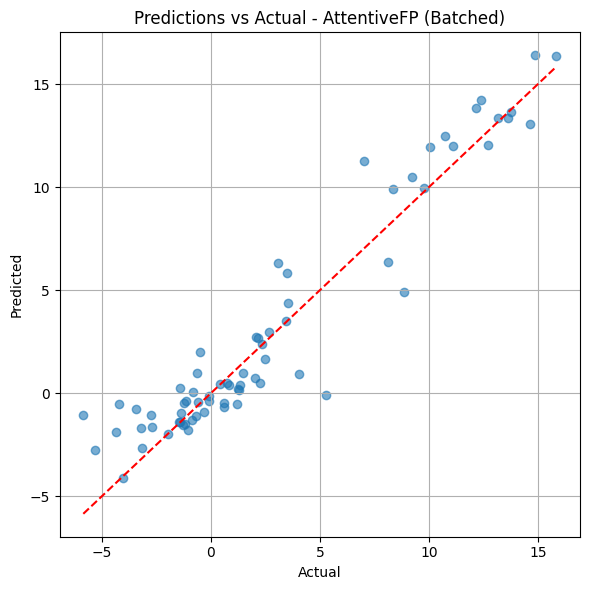

In [12]:
prediction_plot(model, loader)

In [13]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
import torch

def plot_predictions_plotly(dataloader, model, metadata_df=None):
    """
    Function to plot predictions vs actual values using Plotly with hover tooltips.
    
    metadata_df: Optional DataFrame with molecule metadata.
                 Should have at least as many rows as total predictions.
                 Example columns: MoleculeName, SMILES, CAS.
    """
    
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for batch in loader:
            out = model(batch).squeeze()
            y = batch.y.squeeze()
            all_preds.append(out.cpu())
            all_targets.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    
    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")

    # Build DataFrame
    df = pd.DataFrame({
        "Actual": all_targets,
        "Predicted": all_preds
    })

    # Merge metadata if available
    if metadata_df is not None:
        metadata_df = metadata_df.reset_index(drop=True)
        df = pd.concat([df, metadata_df.iloc[:len(df)].reset_index(drop=True)], axis=1)

    # Make plot
    fig = px.scatter(
        df,
        x="Actual",
        y="Predicted",
        hover_data={
            "Inhibitor Name": True,
            "Inh Power": False, #':.2f',
            "CAS Number": False,
            "SMILES": False
        },
        title="Predicted vs Actual - AttentiveFP (Batched)",
        labels={"Actual": "Actual", "Predicted": "Predicted"},
        height=600,
        width=600
    )

    # Identity line y=x
    fig.add_shape(
        type="line",
        x0=df["Actual"].min(),
        y0=df["Actual"].min(),
        x1=df["Actual"].max(),
        y1=df["Actual"].max(),
        line=dict(color="red", dash="dash"),
    )

    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(showlegend=False)
    fig.show()


In [14]:
eval_loader = DataLoader(graph_list, batch_size=32, shuffle=False)
plot_predictions_plotly(eval_loader, model, metadata_df=molecules_df)

R² score: 0.907
RMSE: 1.726


## UMAP Dimensionality Reduction

In [40]:
import torch
import umap
import pandas as pd
import plotly.express as px

# Store everything
all_embeddings = []
all_labels = []

# Model in eval mode
eval_loader = DataLoader(graph_list, batch_size=32, shuffle=False)
model.eval()

with torch.no_grad():
    for batch in eval_loader:
        # Get embeddings
        batch_data = batch.x, batch.edge_index, batch.edge_attr, batch.batch
        all_labels.append(batch.y.cpu())
        
        # Get embeddings
        # If return_embeddings=True, it returns the embeddings before the final layer
        # If return_embeddings=False, it returns the final output
        all_embeddings.append(model.attentivefp(*batch_data).cpu()) 


# Stack them
embeddings = torch.cat(all_embeddings, dim=0).numpy()  # shape: (70, hidden_dim)
labels = torch.cat(all_labels, dim=0).numpy()          # shape: (70,)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [41]:
embeddings.shape, labels.shape

((70, 64), (70,))

In [42]:
import umap

# Create 2D embeddings for plotly plot
reducer = umap.UMAP(n_components=2, random_state=123)
embeddings_2d = reducer.fit_transform(embeddings)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [43]:
df = pd.DataFrame({
    "UMAP1": embeddings_2d[:,0],
    "UMAP2": embeddings_2d[:,1],
    "Label": labels
})

# If you also have names/SMILES:
df["Inhibitor"] = molecules_df["Inhibitor Name"]
df

,UMAP1,UMAP2,Label,Inhibitor
0,4.053130,5.901073,5.29,1-H-imidazole-2-carboxylic acid
1,4.437436,22.922499,10.04,1-methyl-1-H-benzimidazole-2-thiol
2,3.554435,8.684916,-0.51,1-methyl-benzimidazole
3,4.370595,8.674169,2.09,"1,2,4-triazole"
4,4.267693,8.755991,3.54,"1,3-diisopropyl-2-thiourea"
...,...,...,...,...
65,3.598995,8.350233,1.19,Thiosalycylic acid
66,4.239988,8.228873,2.68,Thiourea
67,5.763437,4.426308,-0.88,Triisoproponalamine
68,4.828552,5.529698,-5.85,Tryptamine


In [44]:
fig = px.scatter(
    df,
    x="UMAP1",
    y="UMAP2",
    color="Label",
    hover_data={
        "Inhibitor": True,
        "Label": ':.2f'
    },
    title="UMAP projection of GNN graph embeddings"
)
fig.show()


## Predicting an arbitrary molecule

In [15]:
mol_to_predict = [graph_list[23]]
mol_to_predict[0].y

tensor([1.2800])

In [16]:
from torch_geometric.data import Batch

def predict_single_molecule(model, molecule_graph):
    model.eval()
    with torch.no_grad():
        batch = Batch.from_data_list([molecule_graph])  # wrap in a list

        prediction = model(batch)

        return round(prediction.item(), 4) # scalar output

predicted_value = predict_single_molecule(model, mol_to_predict[0])
predicted_value

0.1755

## Effect of Training Parameters on model performance

Here, we will explore the effects of model training parameters (and small model changes) and how these affect model performance. Namely, we will explore the effects of:
* Number of layers used within the model
* Number of epochs used in training
* Learning rate
* Dropout rate


### Number of Layers

#### 2 Layers

In [17]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import AttentiveFP

class AttentiveFPModel2L(torch.nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, out_dim, num_layers=2, timesteps=2, dropout_rate=0.2):
        super().__init__()

        self.attentivefp = AttentiveFP(
            in_channels=node_dim,
            hidden_channels=hidden_dim,
            out_channels=hidden_dim,  # should match Linear input
            edge_dim=edge_dim,
            num_layers=num_layers,
            num_timesteps=timesteps,
            dropout=dropout_rate
        )

        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, data):
        x = self.attentivefp(data.x, data.edge_index, data.edge_attr, data.batch)
        return self.ffnn(x)


In [21]:
model_2L = AttentiveFPModel2L(
    node_dim=num_node_features,
    edge_dim=num_edge_features,
    hidden_dim=64,
    out_dim=1)
print(model_2L)

AttentiveFPModel2L(
  (attentivefp): AttentiveFP(in_channels=79, hidden_channels=64, out_channels=64, edge_dim=10, num_layers=2, num_timesteps=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


Epoch 1: Loss = 88.9818
Epoch 2: Loss = 123.2855
Epoch 3: Loss = 129.1981
Epoch 4: Loss = 130.6683
Epoch 5: Loss = 101.6711
Epoch 6: Loss = 137.4801
Epoch 7: Loss = 104.2801
Epoch 8: Loss = 101.6421
Epoch 9: Loss = 83.8419
Epoch 10: Loss = 111.3294
Epoch 11: Loss = 120.8763
Epoch 12: Loss = 90.5013
Epoch 13: Loss = 119.2523
Epoch 14: Loss = 99.5245
Epoch 15: Loss = 86.5287
Epoch 16: Loss = 81.1953
Epoch 17: Loss = 108.7304
Epoch 18: Loss = 73.2140
Epoch 19: Loss = 82.3692
Epoch 20: Loss = 99.0274
Epoch 21: Loss = 79.6607
Epoch 22: Loss = 72.1077
Epoch 23: Loss = 84.1463
Epoch 24: Loss = 107.9304
Epoch 25: Loss = 97.4209
Epoch 26: Loss = 68.6692
Epoch 27: Loss = 109.6359
Epoch 28: Loss = 84.8920
Epoch 29: Loss = 99.1479
Epoch 30: Loss = 82.4429
Epoch 31: Loss = 101.6251
Epoch 32: Loss = 108.1065
Epoch 33: Loss = 87.4208
Epoch 34: Loss = 100.7571
Epoch 35: Loss = 80.9672
Epoch 36: Loss = 84.5730
Epoch 37: Loss = 88.4720
Epoch 38: Loss = 74.3375
Epoch 39: Loss = 67.2145
Epoch 40: Loss = 5

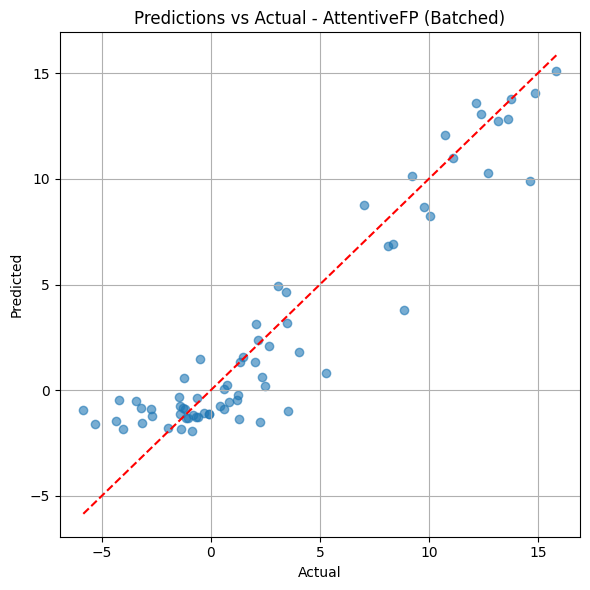

In [22]:
train_attFP_model(model_2L, loader, lr=1e-3, epochs=300)
prediction_plot(model_2L, loader)

#### 3 Layers

In [23]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import AttentiveFP

class AttentiveFPModel3L(torch.nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, out_dim, num_layers=3, timesteps=2, dropout_rate=0.2):
        super().__init__()

        self.attentivefp = AttentiveFP(
            in_channels=node_dim,
            hidden_channels=hidden_dim,
            out_channels=hidden_dim,  # should match Linear input
            edge_dim=edge_dim,
            num_layers=num_layers,
            num_timesteps=timesteps,
            dropout=dropout_rate
        )

        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, data):
        x = self.attentivefp(data.x, data.edge_index, data.edge_attr, data.batch)
        return self.ffnn(x)


In [24]:
model_3L = AttentiveFPModel3L(
    node_dim=num_node_features,
    edge_dim=num_edge_features,
    hidden_dim=64,
    out_dim=1)
print(model_3L)

AttentiveFPModel3L(
  (attentivefp): AttentiveFP(in_channels=79, hidden_channels=64, out_channels=64, edge_dim=10, num_layers=3, num_timesteps=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


Epoch 1: Loss = 101.1538
Epoch 2: Loss = 141.5364
Epoch 3: Loss = 118.1971
Epoch 4: Loss = 87.3761
Epoch 5: Loss = 116.7564
Epoch 6: Loss = 87.9255
Epoch 7: Loss = 100.8984
Epoch 8: Loss = 86.8902
Epoch 9: Loss = 80.2465
Epoch 10: Loss = 85.7637
Epoch 11: Loss = 101.4610
Epoch 12: Loss = 125.3383
Epoch 13: Loss = 76.0915
Epoch 14: Loss = 102.6744
Epoch 15: Loss = 83.0111
Epoch 16: Loss = 95.7783
Epoch 17: Loss = 96.2645
Epoch 18: Loss = 99.2697
Epoch 19: Loss = 85.6061
Epoch 20: Loss = 97.9153
Epoch 21: Loss = 77.7673
Epoch 22: Loss = 98.2605
Epoch 23: Loss = 101.4784
Epoch 24: Loss = 93.6908
Epoch 25: Loss = 100.9106
Epoch 26: Loss = 76.5389
Epoch 27: Loss = 111.6805
Epoch 28: Loss = 90.0040
Epoch 29: Loss = 74.7510
Epoch 30: Loss = 156.0722
Epoch 31: Loss = 78.5940
Epoch 32: Loss = 85.5388
Epoch 33: Loss = 97.3650
Epoch 34: Loss = 69.9487
Epoch 35: Loss = 103.1436
Epoch 36: Loss = 69.2961
Epoch 37: Loss = 80.0526
Epoch 38: Loss = 69.5798
Epoch 39: Loss = 63.7294
Epoch 40: Loss = 66.4

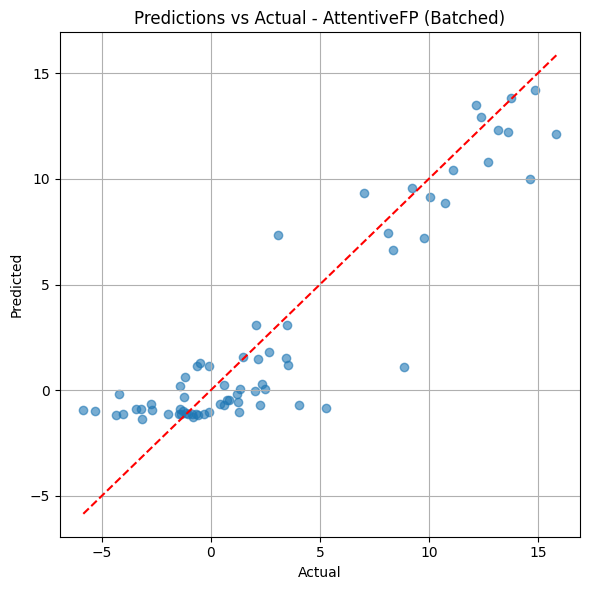

In [25]:
train_attFP_model(model_3L, loader, lr=1e-3, epochs=300)
prediction_plot(model_3L, loader)

### Number of epochs

In [32]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch

def r2_rmse(dataloader, model):
    """
    Function to plot predictions vs actual values.
    This function however returns the R² score and RMSE.
    """

    # Put model in evaluation mode
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for batch in loader:
            out = model(batch).squeeze()
            y = batch.y.squeeze()
            preds.append(out.cpu())
            targets.append(y.cpu())

    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()

    # COmpute metrics
    r2 = r2_score(targets, preds)
    rmse = np.sqrt(mean_squared_error(targets, preds))

    print(f"R²: {r2_score(targets, preds):.3f}")
    print(f"RMSE: {root_mean_squared_error(targets, preds):.3f}")
    
    return r2, rmse



In [33]:
train_epochs = [100, 200, 300, 400, 500]
metrics_epoch = {}
for epoch in train_epochs:
    model_epoch = AttentiveFPModel2L(node_dim=num_node_features, edge_dim=num_edge_features, hidden_dim=64, out_dim=1)
    train_attFP_model(model_epoch, loader, lr=1e-3, epochs=300)
    metrics_epoch[epoch] = r2_rmse(loader, model_epoch)
metrics_epoch

Epoch 1: Loss = 113.0835
Epoch 2: Loss = 110.8866
Epoch 3: Loss = 109.0737
Epoch 4: Loss = 124.4942
Epoch 5: Loss = 125.1419
Epoch 6: Loss = 95.7928
Epoch 7: Loss = 94.4982
Epoch 8: Loss = 115.3105
Epoch 9: Loss = 100.0011
Epoch 10: Loss = 79.4818
Epoch 11: Loss = 104.5885
Epoch 12: Loss = 100.8535
Epoch 13: Loss = 97.1313
Epoch 14: Loss = 138.1622
Epoch 15: Loss = 83.9760
Epoch 16: Loss = 81.7627
Epoch 17: Loss = 92.1770
Epoch 18: Loss = 85.8366
Epoch 19: Loss = 96.5594
Epoch 20: Loss = 94.5992
Epoch 21: Loss = 86.3339
Epoch 22: Loss = 78.5981
Epoch 23: Loss = 83.0904
Epoch 24: Loss = 78.5726
Epoch 25: Loss = 69.8039
Epoch 26: Loss = 68.1108
Epoch 27: Loss = 75.1081
Epoch 28: Loss = 68.0461
Epoch 29: Loss = 61.4644
Epoch 30: Loss = 77.0740
Epoch 31: Loss = 61.5398
Epoch 32: Loss = 74.1751
Epoch 33: Loss = 59.1992
Epoch 34: Loss = 70.3673
Epoch 35: Loss = 56.4676
Epoch 36: Loss = 81.9705
Epoch 37: Loss = 53.2661
Epoch 38: Loss = 58.3275
Epoch 39: Loss = 58.7113
Epoch 40: Loss = 86.8817

{100: (0.8436087369918823, np.float64(2.2393599169577456)),
 200: (0.8753230571746826, np.float64(1.9994509062409849)),
 300: (0.809053361415863, np.float64(2.4744215896278776)),
 400: (0.8419961333274841, np.float64(2.250876150146502)),
 500: (0.8739404082298279, np.float64(2.010507400389027))}

In [35]:
for key, value in metrics_epoch.items():
    print(f"Epoch: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Epoch: 100, R²: 0.844, RMSE: 2.239
Epoch: 200, R²: 0.875, RMSE: 1.999
Epoch: 300, R²: 0.809, RMSE: 2.474
Epoch: 400, R²: 0.842, RMSE: 2.251
Epoch: 500, R²: 0.874, RMSE: 2.011


### Dropout Rates

In [36]:
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
metrics_dropout = {}
for dr in dropout_rates:
    model_dr = AttentiveFPModel2L(node_dim=num_node_features, edge_dim=num_edge_features, hidden_dim=64, out_dim=1, dropout_rate=dr)
    train_attFP_model(model_dr, loader, lr=1e-3, epochs=300)
    metrics_dropout[dr] = r2_rmse(loader, model_dr)
metrics_dropout

Epoch 1: Loss = 99.7966
Epoch 2: Loss = 149.1002
Epoch 3: Loss = 91.7945
Epoch 4: Loss = 112.2522
Epoch 5: Loss = 103.2694
Epoch 6: Loss = 106.7341
Epoch 7: Loss = 133.9250
Epoch 8: Loss = 88.9351
Epoch 9: Loss = 84.2637
Epoch 10: Loss = 119.6833
Epoch 11: Loss = 96.2983
Epoch 12: Loss = 104.1130
Epoch 13: Loss = 92.4203
Epoch 14: Loss = 95.9802
Epoch 15: Loss = 96.3534
Epoch 16: Loss = 114.2946
Epoch 17: Loss = 83.5930
Epoch 18: Loss = 91.0991
Epoch 19: Loss = 88.6499
Epoch 20: Loss = 118.1993
Epoch 21: Loss = 76.3479
Epoch 22: Loss = 116.8510
Epoch 23: Loss = 75.3184
Epoch 24: Loss = 91.3451
Epoch 25: Loss = 81.5558
Epoch 26: Loss = 97.6524
Epoch 27: Loss = 84.9347
Epoch 28: Loss = 81.5840
Epoch 29: Loss = 72.4670
Epoch 30: Loss = 72.1611
Epoch 31: Loss = 59.8993
Epoch 32: Loss = 71.0532
Epoch 33: Loss = 59.3139
Epoch 34: Loss = 80.5618
Epoch 35: Loss = 60.9040
Epoch 36: Loss = 48.0525
Epoch 37: Loss = 49.0602
Epoch 38: Loss = 49.1505
Epoch 39: Loss = 58.2665
Epoch 40: Loss = 76.3392

{0.1: (0.9224035143852234, np.float64(1.5773884782500214)),
 0.2: (0.8061482906341553, np.float64(2.49317391225899)),
 0.3: (0.7703066468238831, np.float64(2.7138883597422145)),
 0.4: (0.6815286874771118, np.float64(3.1956036348783243)),
 0.5: (0.5761843919754028, np.float64(3.686431730026542))}

In [37]:
for key, value in metrics_dropout.items():
    print(f"Dropout Rate: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Dropout Rate: 0.1, R²: 0.922, RMSE: 1.577
Dropout Rate: 0.2, R²: 0.806, RMSE: 2.493
Dropout Rate: 0.3, R²: 0.770, RMSE: 2.714
Dropout Rate: 0.4, R²: 0.682, RMSE: 3.196
Dropout Rate: 0.5, R²: 0.576, RMSE: 3.686


### Learning Rates

In [38]:
learning_rates = [0.1, 0.01, 1e-3, 1e-4, 1e-5]
metrics_lr = {}
for lr in learning_rates:
    model_lr = AttentiveFPModel2L(node_dim=num_node_features, edge_dim=num_edge_features, hidden_dim=64, out_dim=1)
    train_attFP_model(model_lr, loader, lr=lr, epochs=300)
    metrics_lr[lr] = r2_rmse(loader, model_lr)
metrics_lr

Epoch 1: Loss = 5092.2551
Epoch 2: Loss = 52007.8908
Epoch 3: Loss = 821.5751
Epoch 4: Loss = 863.3578
Epoch 5: Loss = 1073.3363
Epoch 6: Loss = 1145.2522
Epoch 7: Loss = 363.2969
Epoch 8: Loss = 567.9141
Epoch 9: Loss = 353.5677
Epoch 10: Loss = 270.8703
Epoch 11: Loss = 1073.2619
Epoch 12: Loss = 180.2327
Epoch 13: Loss = 439.5820
Epoch 14: Loss = 183.4693
Epoch 15: Loss = 2565.2054
Epoch 16: Loss = 152.8273
Epoch 17: Loss = 6402.4757
Epoch 18: Loss = 2281.1597
Epoch 19: Loss = 349.8308
Epoch 20: Loss = 133.8834
Epoch 21: Loss = 130.9509
Epoch 22: Loss = 95.8677
Epoch 23: Loss = 89.8314
Epoch 24: Loss = 83.7618
Epoch 25: Loss = 98.9522
Epoch 26: Loss = 127.3959
Epoch 27: Loss = 84.8797
Epoch 28: Loss = 130.5019
Epoch 29: Loss = 108.4670
Epoch 30: Loss = 107.9438
Epoch 31: Loss = 112.0285
Epoch 32: Loss = 117.0007
Epoch 33: Loss = 88.5852
Epoch 34: Loss = 119.1065
Epoch 35: Loss = 81.6629
Epoch 36: Loss = 80.4833
Epoch 37: Loss = 129.4479
Epoch 38: Loss = 142.3657
Epoch 39: Loss = 102

{0.1: (-0.0002562999725341797, np.float64(5.663349564506408)),
 0.01: (0.6328856348991394, np.float64(3.4309817850312627)),
 0.001: (0.8085266947746277, np.float64(2.4778319754420295)),
 0.0001: (0.49864405393600464, np.float64(4.009505184019433)),
 1e-05: (-0.10147011280059814, np.float64(5.942977787721536))}

In [39]:
for key, value in metrics_lr.items():
    print(f"Dropout Rate: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Dropout Rate: 0.1, R²: -0.000, RMSE: 5.663
Dropout Rate: 0.01, R²: 0.633, RMSE: 3.431
Dropout Rate: 0.001, R²: 0.809, RMSE: 2.478
Dropout Rate: 0.0001, R²: 0.499, RMSE: 4.010
Dropout Rate: 1e-05, R²: -0.101, RMSE: 5.943
